In [44]:
import pyopencl as cl
import pyopencl.array
import numpy as np
import numpy.linalg as la
import cv2

In [45]:
import matplotlib.pyplot as plt
import math
import matplotlib.patches as mpatches
plt.style.use('ggplot')
font = {
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [20,20]


In [46]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
prg = cl.Program(ctx, """
    __kernel void box_counting(__global int *img, const unsigned int t,  const unsigned int size_group,__global int *group_indexs, __global int *groups_result)
    {
        int gid0 = get_global_id(0);
        int gid1 = get_global_id(1);
        int size = get_global_size(0);
        int i = gid1 * size + gid0;
        int kf = 0;
        int kc = 0;
        int group = 0;

        if(img[i] != 255){

            for(int j = 0; j<(size/t)+1; j++){
                if(group_indexs[j]>gid0){
                    kc = j-1;
                    break;
                }
            }

            for(int j = 0; j<(size/t)+1; j++){
                if(group_indexs[j]>gid1){
                    kf = j-1;
                    break;
                }
            }

            group = kf * size_group + kc;
            groups_result[group] = groups_result[group]+1;
        }

    }

    """).build()

In [47]:
import glob

In [48]:
limage = np.array(list(sorted(glob.glob("img_seleccionadas/*.png"))))
#limage = pendientes[np.array(pendientes[:,0],dtype=np.float32) > 5,1]

In [49]:
np.shape(limage)[0]/3

12.0

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


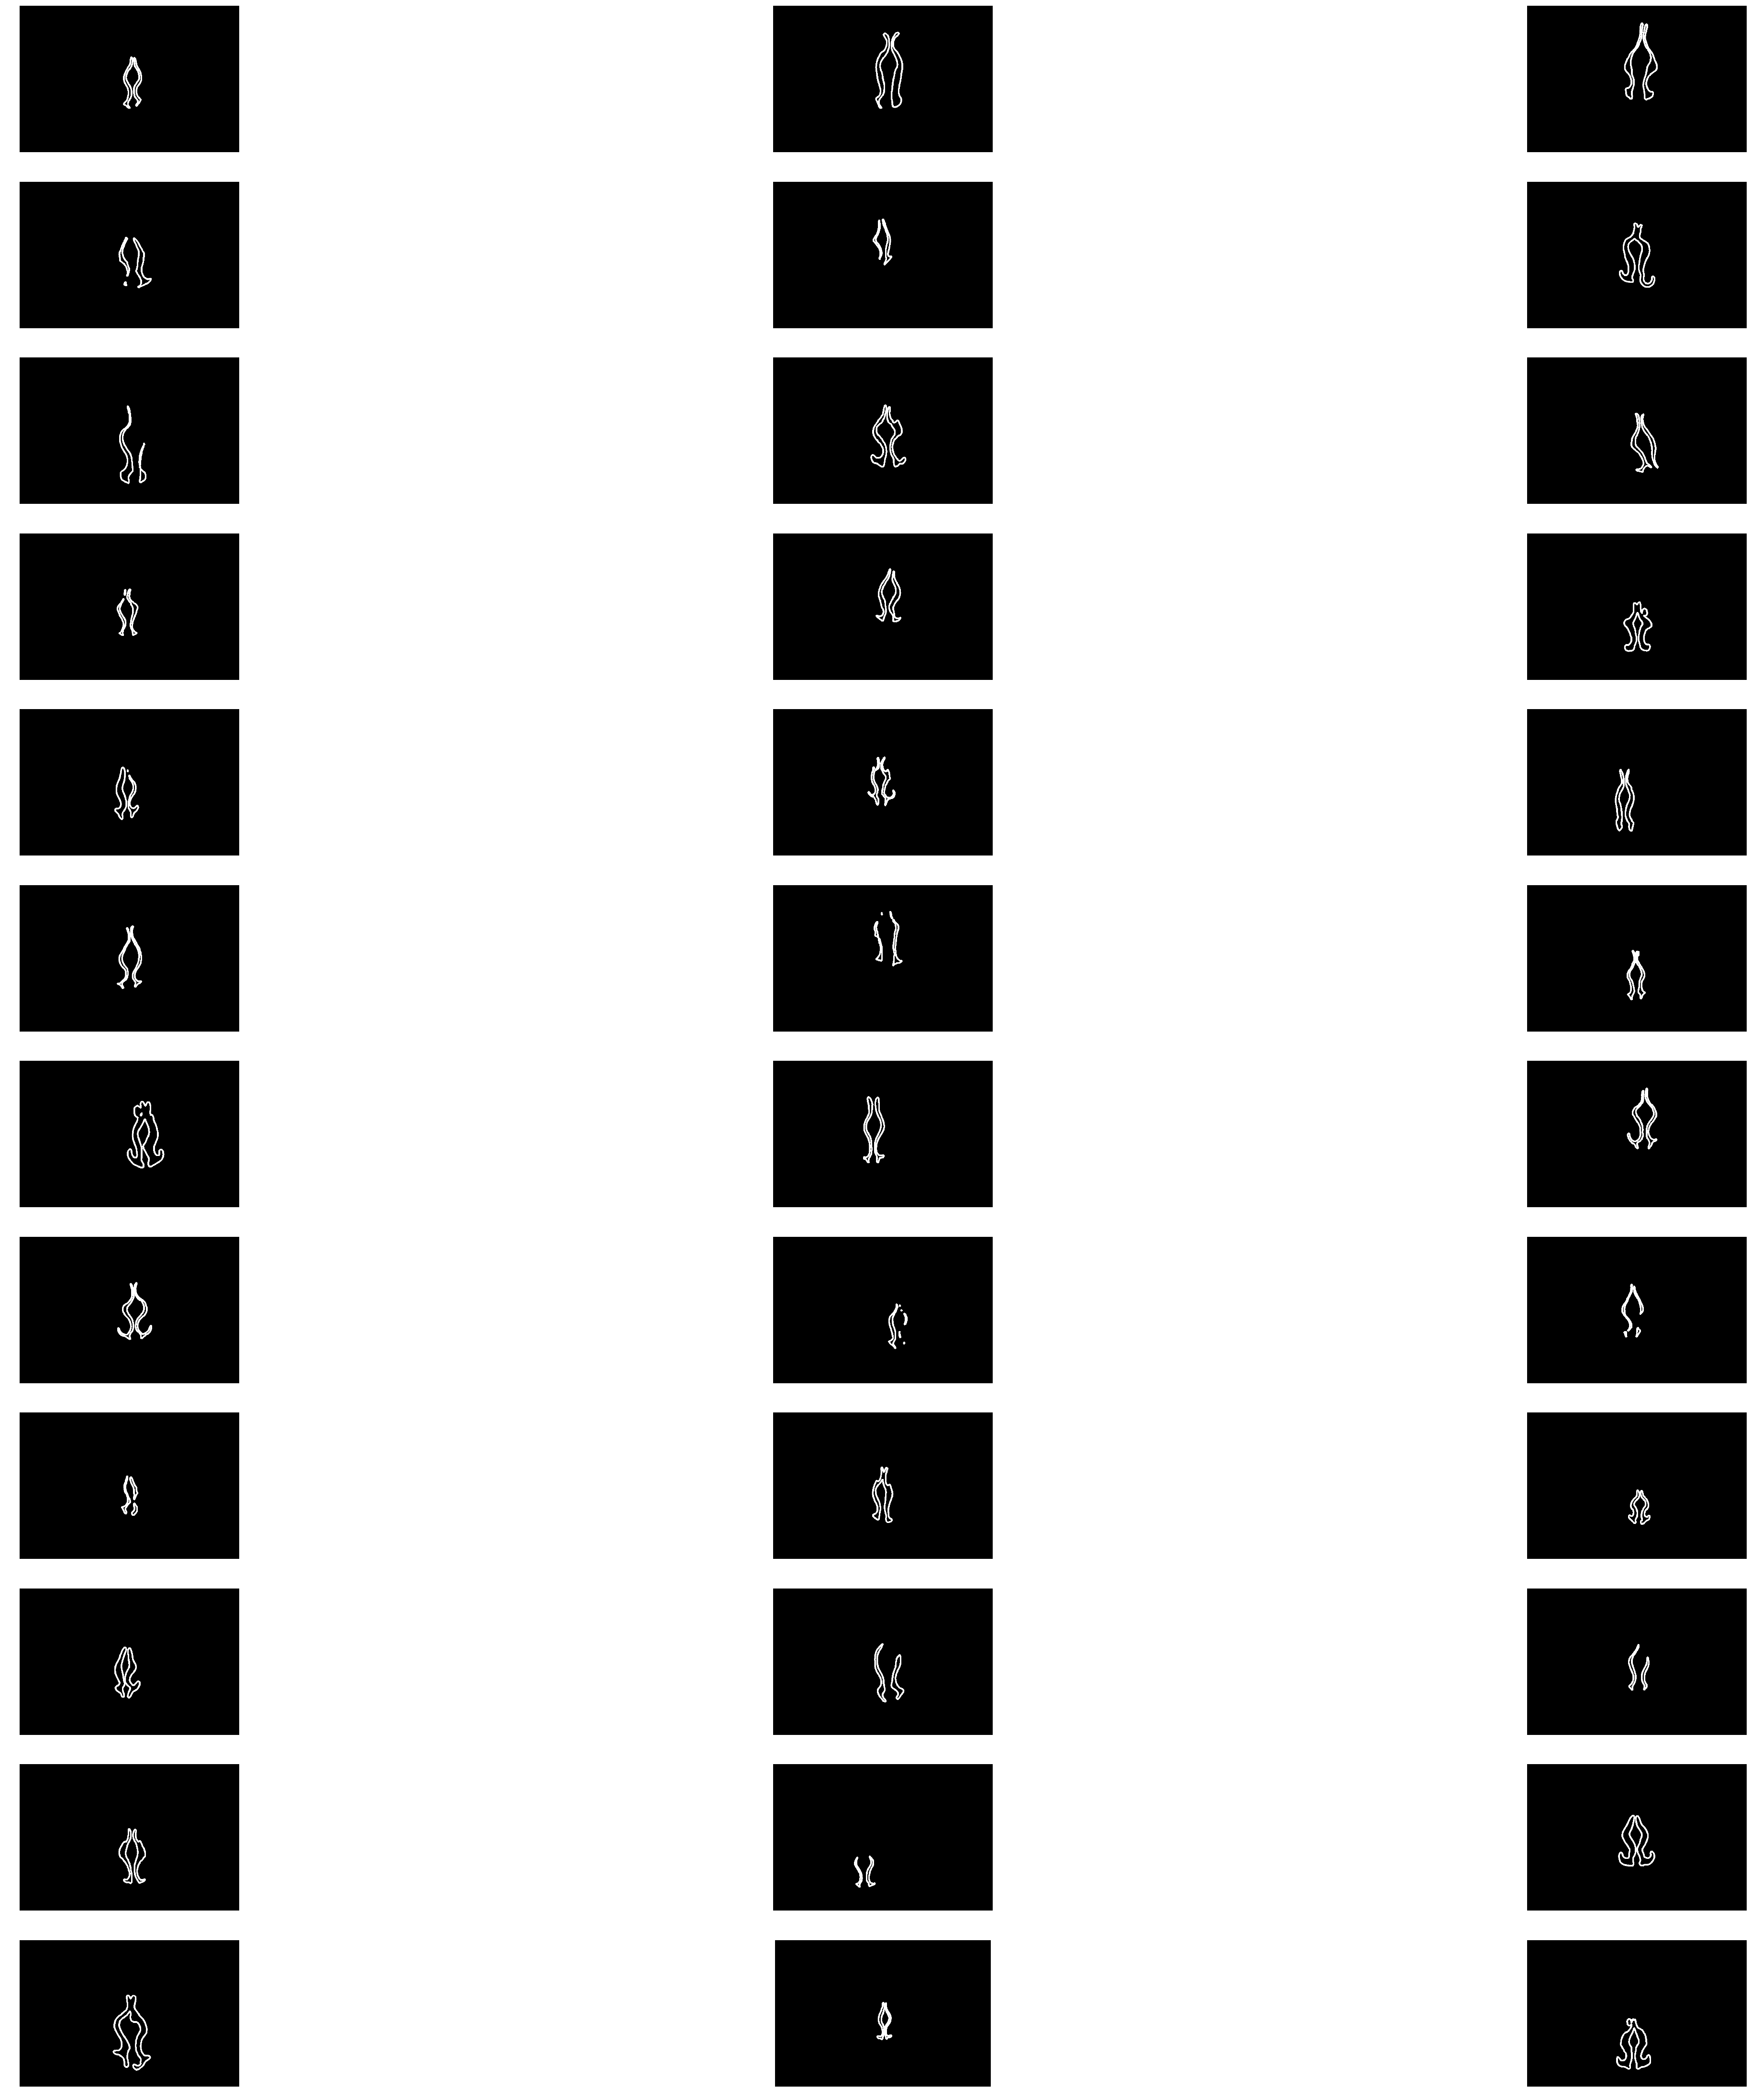

In [50]:
f, axarr = plt.subplots(12,3,figsize=(80,80))
x = 0
y = 0
for r_img in limage:
    
    img = cv2.imread(r_img,0)
    axarr[y][x].set_aspect("equal")
    axarr[y][x].axis('off')
    axarr[y][x].imshow(img,cmap=plt.cm.gray_r)
        #plt.set_aspect("equal")
        #plt.imshow(np.ones_like(img)*255,cmap=plt.cm.gray_r)
        #plt.plot(contour[:, 1], contour[:, 0],"k", linewidth=10)
    x = x + 1
    if x > 2:
        y = y +1
        x = 0
plt.show()

In [51]:
result_total = []
for r in limage:
    size = 1024
    gray = cv2.imread(r,0)
    #gray = cv2.imread("slices/neander/slice-10.png",0)
    gray = cv2.resize(gray,(size,size), interpolation = cv2.INTER_CUBIC)
    img = gray.astype(np.int32)
    result = []
    for t in 2**np.array((range(1,9))):
        group_indexs = np.array([i * t for i in range(0,(size//t)+1)],dtype=np.int32)
        groups_result = np.zeros((size//t,size//t)).astype(np.int32)
        size_group = np.shape(group_indexs)[0] -1 
        img_dev = cl.array.to_device(queue, img)
        group_indexs_dev = cl.array.to_device(queue, group_indexs)
        groups_result_dev = cl.array.to_device(queue, groups_result)
        prg.box_counting(queue, img_dev.shape, None, img_dev.data,np.int32(t),np.int32(size_group),group_indexs_dev.data,groups_result_dev.data)
        groups_result = groups_result_dev.get()
        result.append((t,np.shape(groups_result[groups_result!=0])[0]))
    result_total.append(result)
    print(result)

[(2, 3863), (4, 1116), (8, 329), (16, 104), (32, 34), (64, 13), (128, 7), (256, 4)]
[(2, 6005), (4, 1800), (8, 582), (16, 199), (32, 68), (64, 29), (128, 10), (256, 6)]
[(2, 6011), (4, 1747), (8, 544), (16, 183), (32, 66), (64, 23), (128, 10), (256, 5)]
[(2, 3801), (4, 1134), (8, 370), (16, 130), (32, 44), (64, 17), (128, 6), (256, 4)]
[(2, 2956), (4, 859), (8, 256), (16, 90), (32, 30), (64, 11), (128, 6), (256, 4)]
[(2, 5433), (4, 1633), (8, 540), (16, 194), (32, 64), (64, 23), (128, 8), (256, 4)]
[(2, 4117), (4, 1224), (8, 399), (16, 143), (32, 59), (64, 21), (128, 10), (256, 6)]
[(2, 5747), (4, 1705), (8, 544), (16, 181), (32, 62), (64, 22), (128, 10), (256, 6)]
[(2, 4678), (4, 1375), (8, 428), (16, 134), (32, 49), (64, 18), (128, 8), (256, 6)]
[(2, 3350), (4, 966), (8, 298), (16, 101), (32, 35), (64, 12), (128, 6), (256, 4)]
[(2, 4311), (4, 1281), (8, 406), (16, 132), (32, 46), (64, 16), (128, 7), (256, 5)]
[(2, 4237), (4, 1287), (8, 428), (16, 151), (32, 48), (64, 15), (128, 8), (

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


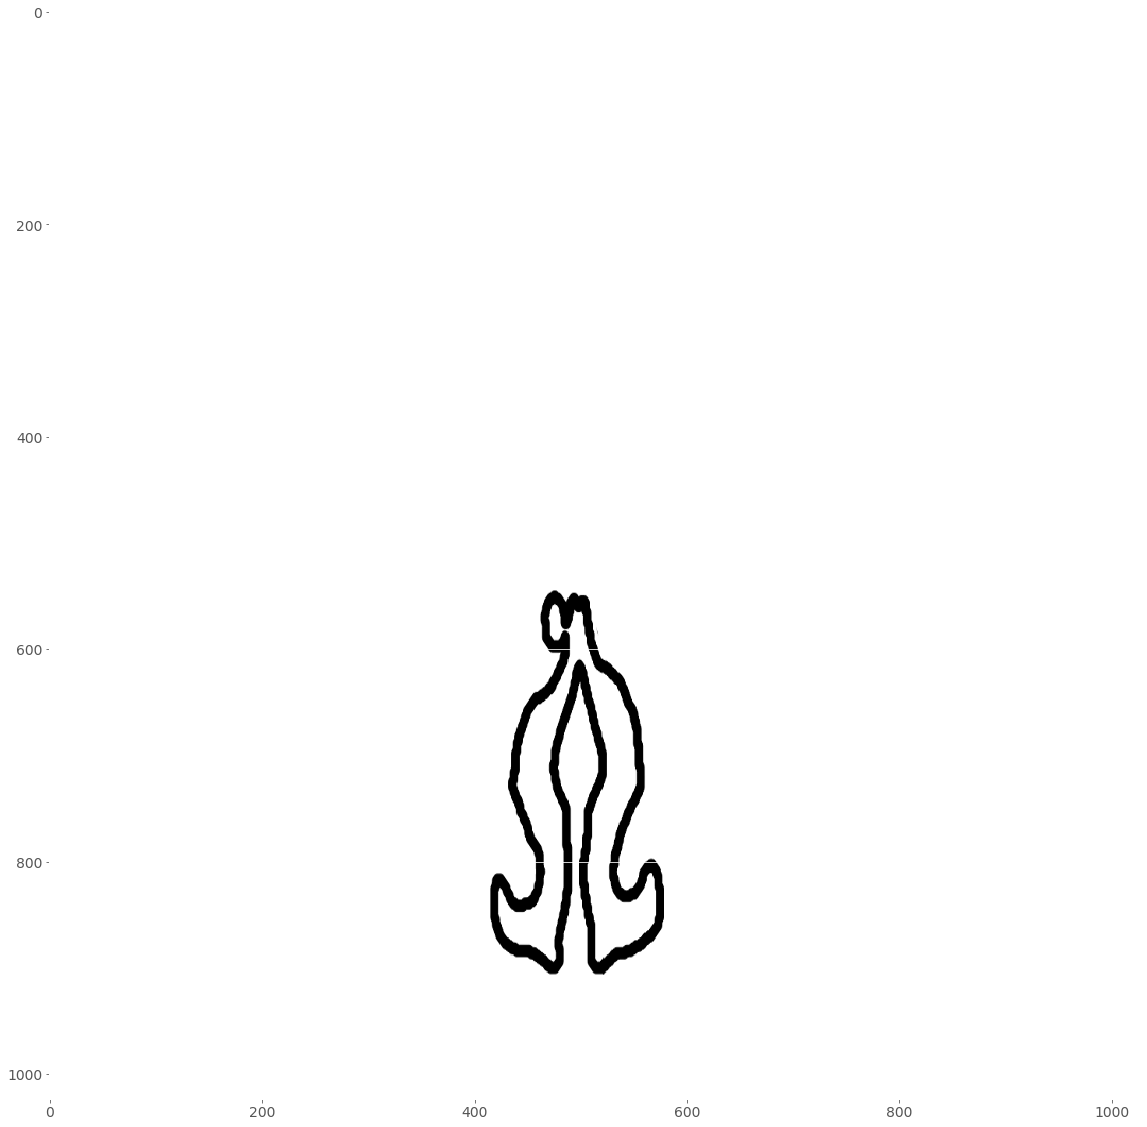

In [52]:
plt.imshow(gray,cmap='gray')
plt.show()

In [53]:
labls = [
    'RossiJavier',
    'alimargarita',
    'Aprile',
    'Aye',
    'Tagliero',
    'Kokuba'
]

In [54]:
colors = [
    'r',
    'b',
    'g',
    'y',
    'm',
    'c',   
]

In [55]:
np.shape(result_total)

(36, 8, 2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


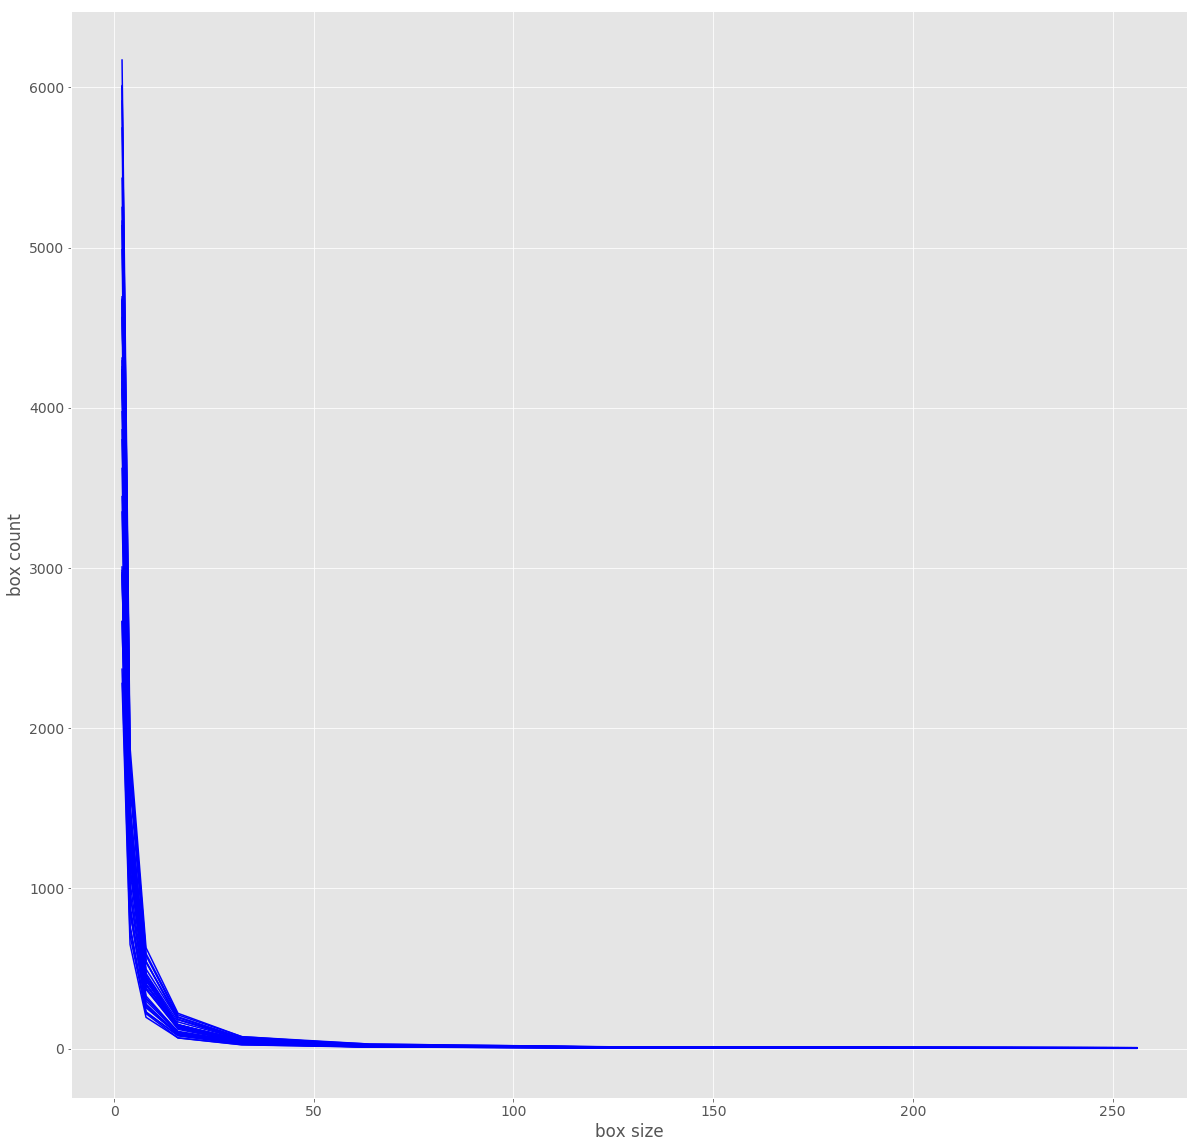

In [56]:
patchs = [] 
#for r,l,c in zip(result_total,labls,colors):
for r in result_total:
    calc = np.array(r)
    #plt.plot(calc[:,0],calc[:,1],'-'+c)
    plt.plot(calc[:,0],calc[:,1],'-b')
    plt.xlabel("box size")
    plt.ylabel("box count")
#    patchs.append(mpatches.Patch(color=c, label=l))
#plt.legend(handles=patchs)
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


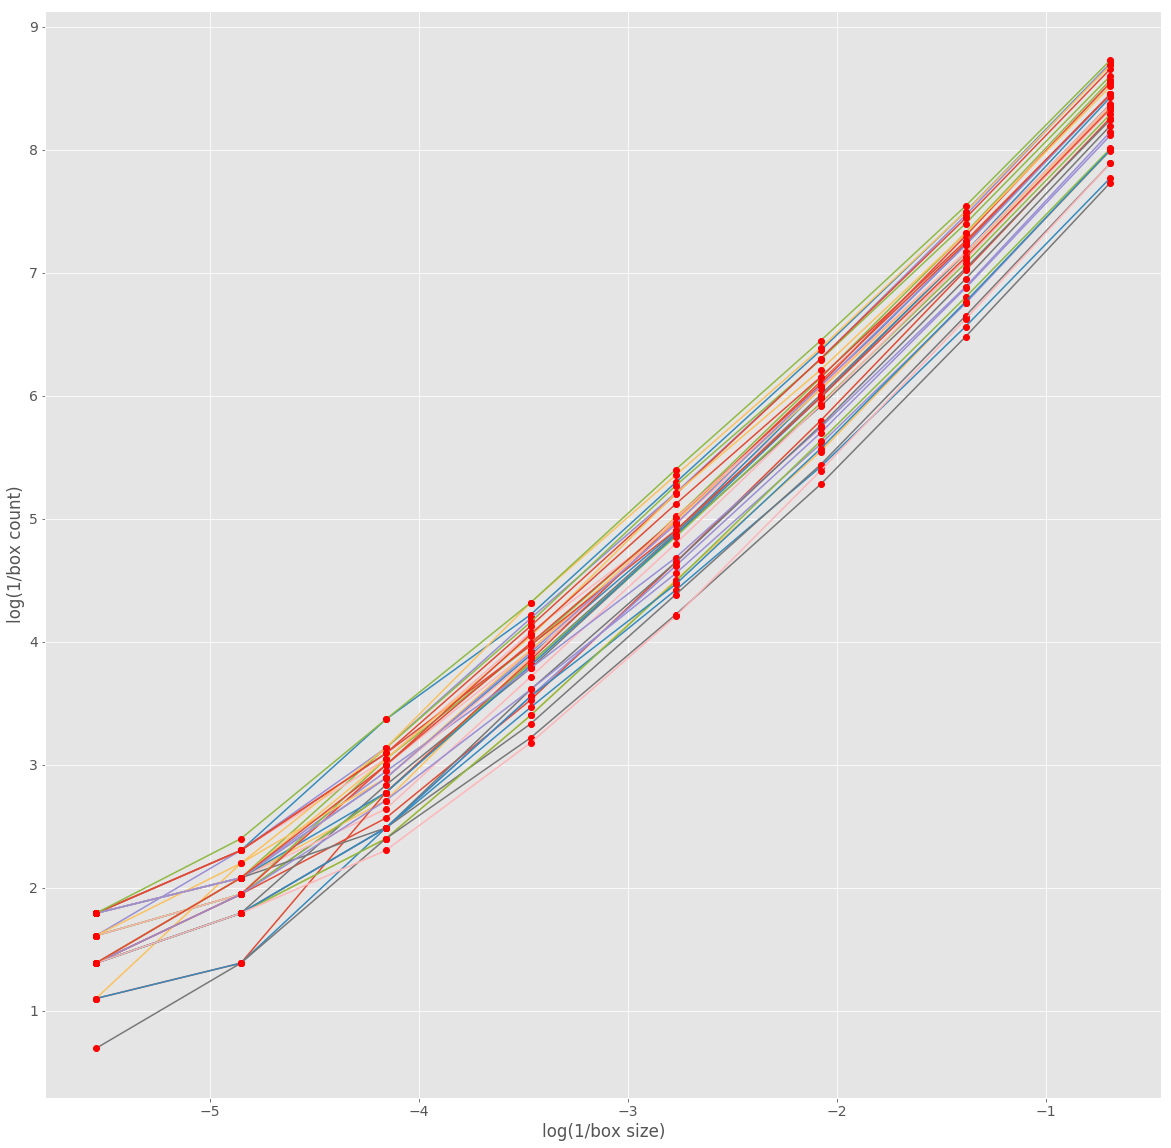

In [57]:
#patchs = [] 
#for r,l,c in zip(result_total,labls,colors):
for r in result_total:
    calc = np.array(r)
    calc_log = np.array(list(map(lambda x: [math.log(1/x[0]),math.log(x[1])] ,calc)))
    #plt.plot(calc_log[:,0],calc_log[:,1],'-'+c)
    plt.plot(calc_log[:,0],calc_log[:,1],'-')
    plt.plot(calc_log[:,0],calc_log[:,1],'or')
    #plt.plot(calc_log[calc_log.shape[0]-1:calc_log.shape[0],0],calc_log[calc_log.shape[0]-1:calc_log.shape[0],1],'or')
    plt.xlabel("log(1/box size)")
    plt.ylabel("log(1/box count)")
    #patchs.append(mpatches.Patch(color=c, label=l))
#plt.legend(handles=patchs)
plt.show()

In [58]:
pendientes = []
for r,ruta_img in zip(result_total,limage):
    calc = np.array(r)
    calc_log = np.array(list(map(lambda x: [math.log(1/x[0]),math.log(x[1])] ,calc)))
    m = calc_log[-1][1]- calc_log[0][1] / calc_log[-1][0] - calc_log[0][0]
    pendientes.append([m,ruta_img])
    print(m,ruta_img)
    #plt.plot(calc_log[:,0],calc_log[:,1],'or')
    

3.56887978696 img_seleccionadas/0.png
4.05390021611 img_seleccionadas/1.png
3.87175875608 img_seleccionadas/11.png
3.56596195541 img_seleccionadas/12.png
3.52062036095 img_seleccionadas/13.png
3.63038320814 img_seleccionadas/14.png
3.98582886645 img_seleccionadas/16.png
4.04598081652 img_seleccionadas/17.png
4.00886616808 img_seleccionadas/18.png
3.54318471421 img_seleccionadas/19.png
3.81181094889 img_seleccionadas/2.png
3.99101007646 img_seleccionadas/20.png
3.79722284819 img_seleccionadas/21.png
3.58558752573 img_seleccionadas/22.png
3.31629631236 img_seleccionadas/23.png
3.59895192622 img_seleccionadas/24.png
3.95374502307 img_seleccionadas/25.png
3.96272800366 img_seleccionadas/26.png
3.35806026137 img_seleccionadas/27.png
3.84738215304 img_seleccionadas/28.png
3.84443908401 img_seleccionadas/29.png
3.62028033647 img_seleccionadas/3.png
3.19301727963 img_seleccionadas/30.png
3.5223809437 img_seleccionadas/31.png
3.50206680537 img_seleccionadas/32.png
3.80949539743 img_seleccionada

In [59]:
pendientes = np.array(pendientes)

In [60]:
pendientes[np.array(pendientes[:,0],dtype=np.float32) > 2.5,1]

array(['img_seleccionadas/0.png', 'img_seleccionadas/1.png',
       'img_seleccionadas/11.png', 'img_seleccionadas/12.png',
       'img_seleccionadas/13.png', 'img_seleccionadas/14.png',
       'img_seleccionadas/16.png', 'img_seleccionadas/17.png',
       'img_seleccionadas/18.png', 'img_seleccionadas/19.png',
       'img_seleccionadas/2.png', 'img_seleccionadas/20.png',
       'img_seleccionadas/21.png', 'img_seleccionadas/22.png',
       'img_seleccionadas/23.png', 'img_seleccionadas/24.png',
       'img_seleccionadas/25.png', 'img_seleccionadas/26.png',
       'img_seleccionadas/27.png', 'img_seleccionadas/28.png',
       'img_seleccionadas/29.png', 'img_seleccionadas/3.png',
       'img_seleccionadas/30.png', 'img_seleccionadas/31.png',
       'img_seleccionadas/32.png', 'img_seleccionadas/33.png',
       'img_seleccionadas/34.png', 'img_seleccionadas/35.png',
       'img_seleccionadas/37.png', 'img_seleccionadas/38.png',
       'img_seleccionadas/40.png', 'img_seleccionadas/41.pn